<h1>Thêm thư viện cần thiết

In [7]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.utils import column_or_1d

warnings.filterwarnings('ignore')


<h1>Nạp dữ liệu

In [8]:
df_train = pd.read_csv("../../../Dataset/bitcoin_train_9_1.csv", parse_dates=True,
                       index_col=0).drop(columns=['Close', 'High', 'Low', 'Volume', 'Currency'])
df_index_train = df_train.index
df_train.head()


,Open
Date,
2020-06-01,9.4545
2020-06-02,10.1907
2020-06-03,9.5270
2020-06-04,9.6672
2020-06-05,9.7940


In [9]:
df_test = pd.read_csv("../../../Dataset/bitcoin_test_9_1.csv", parse_dates=True,
                      index_col=0).drop(columns=['Close', 'High', 'Low', 'Volume', 'Currency'])
df_index_test = df_test.index
df_test.head()


,Open
Date,
2022-03-21,41.282
2022-03-22,41.022
2022-03-23,42.373
2022-03-24,42.911
2022-03-25,44.013


# Tạo mới cột Timestamp để dự báo theo chuỗi thời gian

In [10]:
df_train['Timestamp'] = pd.to_datetime(df_train.index).astype(np.int64) / 10**9
df_train.head()


,Open,Timestamp
Date,,
2020-06-01,9.4545,1.590970e+09
2020-06-02,10.1907,1.591056e+09
2020-06-03,9.5270,1.591142e+09
2020-06-04,9.6672,1.591229e+09
2020-06-05,9.7940,1.591315e+09


In [11]:
df_test['Timestamp'] = pd.to_datetime(df_test.index).astype(np.int64) / 10**9
df_test.head()


,Open,Timestamp
Date,,
2022-03-21,41.282,1.647821e+09
2022-03-22,41.022,1.647907e+09
2022-03-23,42.373,1.647994e+09
2022-03-24,42.911,1.648080e+09
2022-03-25,44.013,1.648166e+09


# Vẽ đồ thị

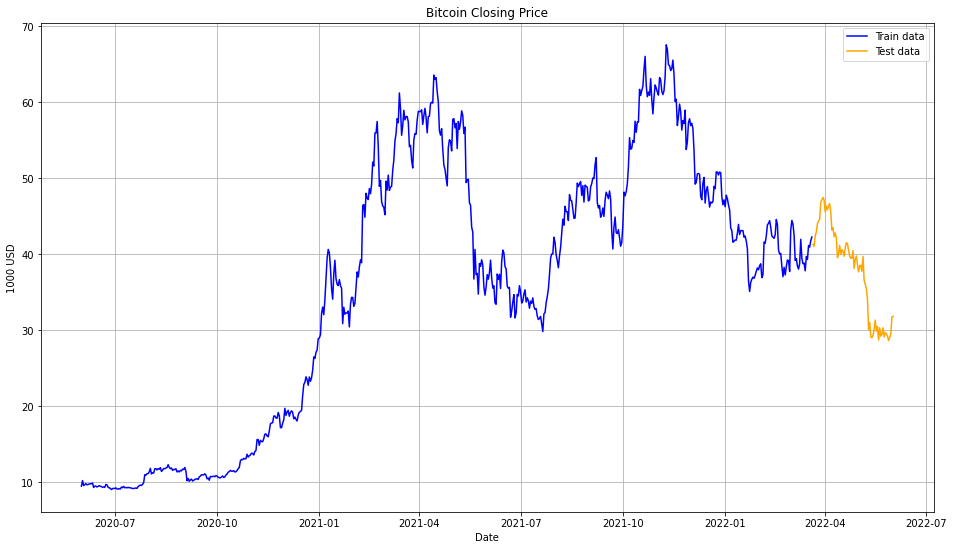

In [12]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.title("Bitcoin Closing Price")
plt.xlabel('Date')
plt.ylabel('1000 USD')
plt.plot(df_train['Open'], 'blue', label='Train data')
plt.plot(df_test['Open'], 'orange', label='Test data')
plt.legend()


# Thực hiện xây dựng mô hình SVR

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [13]:
X_sc_train = StandardScaler()
y_sc_train = StandardScaler()

x_train = df_train.iloc[:, 1].values.reshape(-1, 1)
y_train = df_train.iloc[:, 0].values.reshape(-1, 1)


X_scaled_train = X_sc_train.fit_transform(x_train)
y_scaled_train = y_sc_train.fit_transform(y_train)


df_scaled_train = pd.DataFrame(index=df_index_train)
df_scaled_train['Timestamp'] = X_scaled_train
df_scaled_train['Open'] = y_scaled_train
df_scaled_train.head()


,Timestamp,Open
Date,,
2020-06-01,-1.729421,-1.484146
2020-06-02,-1.724156,-1.442068
2020-06-03,-1.718891,-1.480002
2020-06-04,-1.713627,-1.471989
2020-06-05,-1.708362,-1.464741


In [14]:
X_sc_test = StandardScaler()
y_sc_test = StandardScaler()

x_test = df_test.iloc[:, 1].values.reshape(-1, 1)
y_test = df_test.iloc[:, 0].values.reshape(-1, 1)


X_scaled_test = X_sc_test.fit_transform(x_test)
y_scaled_test = y_sc_test.fit_transform(y_test)


df_scaled_test = pd.DataFrame(index=df_index_test)
df_scaled_test['Timestamp'] = X_scaled_test
df_scaled_test['Open'] = y_scaled_test
df_scaled_test.head()


,Timestamp,Open
Date,,
2022-03-21,-1.708484,0.573612
2022-03-22,-1.661026,0.530782
2022-03-23,-1.613569,0.753330
2022-03-24,-1.566111,0.841954
2022-03-25,-1.518653,1.023484


# Xác định biến độc lập (X) và biến phụ thuộc (y)

In [15]:
X_train = df_scaled_train['Timestamp'].values.reshape(-1, 1)
y_train = df_scaled_train['Open'].values.reshape(-1, 1)

X_test = df_scaled_test['Timestamp'].values.reshape(-1, 1)
y_test = df_scaled_test['Open'].values.reshape(-1, 1)


## Hàm tạo hyperparameters

In [16]:
def para_range(minimum, maximum, step):
    para_list = np.arange(minimum, maximum, step)
    return para_list


# Hàm xuất kết quả của từng trường hợp trong GridSearch

In [17]:
def print_stats(hyperparams, stats):
    if(hyperparams[0] == 'poly'):
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}, degree={hyperparams[3]}')
    else:
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}')

    print(
        f"MAE={stats[0]:.2f} | MAPE={stats[1]:.2f} | MSE={stats[2] :.2f} | RMSE={stats[3]:.2f}")


# Tạo các giá trị cho các hyperparameters

In [18]:
kernels = ['sigmoid', 'rbf', 'poly']
Cs = para_range(0.01, 0.2, 0.1)
gammas = para_range(0.1, 5, 0.1)
degrees = para_range(1, 6, 1)


## GridSearch để tìm hyperparameters phù hợp

In [19]:
warnings.filterwarnings('ignore')

stats_df = pd.DataFrame(
    columns=['kernel', 'C', 'gamma', 'degree', 'MAE', 'MAPE', 'MSE', 'RMSE'])

# Sử dụng gird-seach để tìm hyperparameters phù hợp
for ker in kernels:
    # Nếu kernel == poly thì thực hiện chọn degree
    if(ker != 'poly'):
        for C in Cs:
            for gamma in gammas:
                rgs = SVR(kernel=ker, C=C, gamma=gamma, verbose=False)
                rgs.fit(X_train, y_train)
                pred = rgs.predict(X_test)

                # Đảo tỷ lệ thành giá trị thực
                inv_pred = y_sc_test.inverse_transform(
                    column_or_1d(pred).reshape(-1, 1))
                inv_test = y_sc_test.inverse_transform(
                    column_or_1d(y_test).reshape(-1, 1))
                    
                # Đánh giá mô hình
                mae = mean_absolute_error(inv_test, inv_pred)
                mape = mean_absolute_percentage_error(inv_test, inv_pred)
                mse = mean_squared_error(inv_test, inv_pred)
                rmse = np.sqrt(mse)

                result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': 0,
                          'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                hyperparam = [ker, C, gamma, 0]
                stats = [mae, mape, mse, rmse]
                stats_df = stats_df.append(result, ignore_index=True)
                print_stats(hyperparam, stats)
    else:
        for C in Cs:
            for gamma in gammas:
                for deg in degrees:
                    rgs = SVR(kernel=ker, C=C, gamma=gamma, degree=deg, verbose=False)
                    rgs.fit(X_train, y_train.reshape(-1, 1))
                    pred = rgs.predict(X_test)

                    # Đảo tỷ lệ thành giá trị thực
                    inv_pred = y_sc_test.inverse_transform(
                        column_or_1d(pred).reshape(-1, 1))
                    inv_test = y_sc_test.inverse_transform(
                        column_or_1d(y_test).reshape(-1, 1))

                    # Đánh giá mô hình
                    mae = mean_absolute_error(inv_test, inv_pred)
                    mape = mean_absolute_percentage_error(inv_test, inv_pred)
                    mse = mean_squared_error(inv_test, inv_pred)
                    rmse = np.sqrt(mse)

                    result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': deg,
                            'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                    hyperparam = [ker, C, gamma, deg]
                    stats = [mae, mape, mse, rmse]

                    stats_df = stats_df.append(result, ignore_index=True)

                    print_stats(hyperparam, stats)


SVR(kernel=sigmoid, C=0.01, gamma=0.1
MAE=6.80 | MAPE=0.19 | MSE=60.48 | RMSE=7.78
SVR(kernel=sigmoid, C=0.01, gamma=0.2
MAE=7.82 | MAPE=0.22 | MSE=78.33 | RMSE=8.85
SVR(kernel=sigmoid, C=0.01, gamma=0.30000000000000004
MAE=8.55 | MAPE=0.23 | MSE=92.72 | RMSE=9.63
SVR(kernel=sigmoid, C=0.01, gamma=0.4
MAE=9.14 | MAPE=0.25 | MSE=105.51 | RMSE=10.27
SVR(kernel=sigmoid, C=0.01, gamma=0.5
MAE=9.30 | MAPE=0.25 | MSE=109.05 | RMSE=10.44
SVR(kernel=sigmoid, C=0.01, gamma=0.6
MAE=9.41 | MAPE=0.26 | MSE=111.51 | RMSE=10.56
SVR(kernel=sigmoid, C=0.01, gamma=0.7000000000000001
MAE=9.47 | MAPE=0.26 | MSE=112.37 | RMSE=10.60
SVR(kernel=sigmoid, C=0.01, gamma=0.8
MAE=9.48 | MAPE=0.26 | MSE=112.31 | RMSE=10.60
SVR(kernel=sigmoid, C=0.01, gamma=0.9
MAE=9.51 | MAPE=0.26 | MSE=112.35 | RMSE=10.60
SVR(kernel=sigmoid, C=0.01, gamma=1.0
MAE=9.49 | MAPE=0.26 | MSE=111.23 | RMSE=10.55
SVR(kernel=sigmoid, C=0.01, gamma=1.1
MAE=9.43 | MAPE=0.26 | MSE=109.05 | RMSE=10.44
SVR(kernel=sigmoid, C=0.01, gamma=1.2000

In [20]:
best_fit_model = stats_df[stats_df['MAPE']
                          == stats_df['MAPE'].min()].head(1)
best_fit_model


,kernel,C,gamma,degree,MAE,MAPE,MSE,RMSE
312,poly,0.01,2.4,2,5.185996,0.140127,41.431812,6.436755


In [21]:
kernel = str(best_fit_model['kernel'].values[0])
C = float(best_fit_model['C'])
gamma = float(best_fit_model['gamma'])
degree = int(best_fit_model['degree'])

if(kernel == 'poly'):
    rgs = SVR(kernel=kernel, C=C, gamma=gamma, degree=degree)
else:
    rgs = SVR(kernel=kernel, C=C, gamma=gamma)
    
rgs.fit(X_train, y_train.reshape(-1, 1))
pred = rgs.predict(X_test)
pred

array([-1.11177579, -1.02346954, -0.93765079, -0.85431954, -0.77347579,
       -0.69511954, -0.61925079, -0.54586954, -0.47497579, -0.40656954,
       -0.34065079, -0.27721954, -0.21627579, -0.15781954, -0.1018508 ,
       -0.04836955,  0.0026242 ,  0.05113045,  0.0971492 ,  0.14068045,
        0.1817242 ,  0.22028045,  0.2563492 ,  0.28993045,  0.3210242 ,
        0.34963045,  0.3757492 ,  0.39938045,  0.4205242 ,  0.43918045,
        0.4553492 ,  0.46903045,  0.4802242 ,  0.48893045,  0.4951492 ,
        0.49888045,  0.5001242 ,  0.49888045,  0.4951492 ,  0.48893045,
        0.4802242 ,  0.46903045,  0.4553492 ,  0.43918045,  0.4205242 ,
        0.39938045,  0.3757492 ,  0.34963045,  0.3210242 ,  0.28993045,
        0.2563492 ,  0.22028045,  0.1817242 ,  0.14068045,  0.0971492 ,
        0.05113045,  0.0026242 , -0.04836955, -0.1018508 , -0.15781954,
       -0.21627579, -0.27721954, -0.34065079, -0.40656954, -0.47497579,
       -0.54586954, -0.61925079, -0.69511954, -0.77347579, -0.85

<h1>Đưa dữ liệu về miền giá trị ban đầu

In [22]:
inv_pred = y_sc_test.inverse_transform(
    column_or_1d(pred).reshape(-1, 1))
inv_test = y_sc_test.inverse_transform(
    column_or_1d(y_test).reshape(-1, 1))


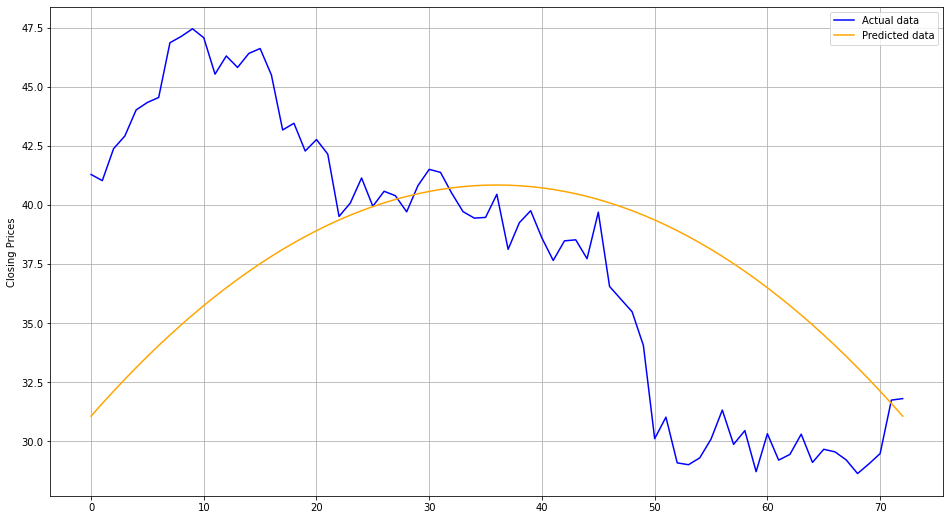

In [23]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'orange', label='Predicted data')
plt.legend()


# Đánh giá mô hình

In [24]:
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"R2: {r2:.2f}")


RMSE: 6.44
MAPE: 14.01%
R2: -0.12
